In [1]:
import symnum
import symnum.numpy as snp
import simsde
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, lax, vmap
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
import mici
import arviz
import corner
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

In [2]:
def drift_func(x, θ):
    S, I, C = x
    α, β, σ, λ, N = θ
    return snp.array([
        -C * S * I / N,
        (C * S * I / N - λ * I),
        (α * (β - snp.log(C)) + σ**2 / 2) * C
    ])

def diff_coeff(x, θ):
    S, I, C = x
    α, β, σ, λ, N = θ
    return snp.array([
        [snp.sqrt(C * S * I / N), 0, 0],
        [-snp.sqrt(C * S * I / N), snp.sqrt(λ * I), 0],
        [0, 0, σ * C]
    ])

dim_x = 3
dim_w = 3
dim_θ = 5

Text(0.5, 0, 'Time')

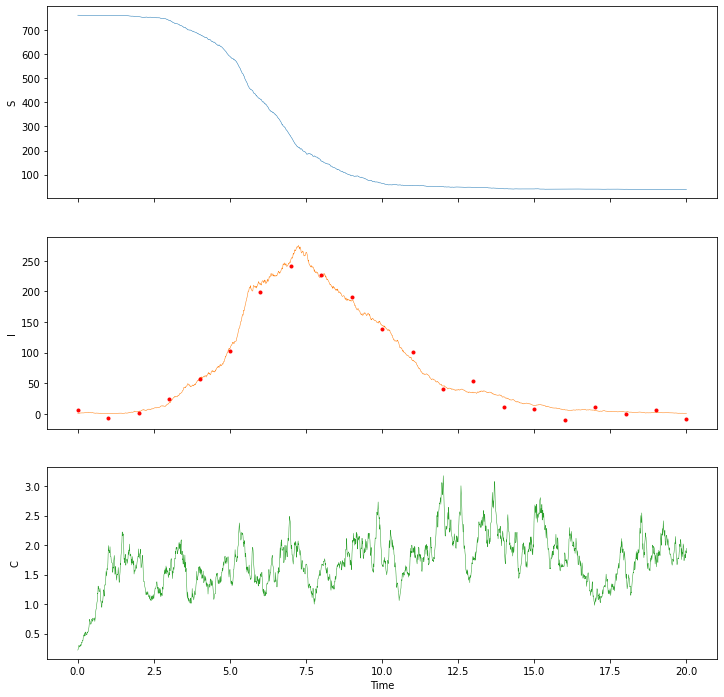

In [3]:
dim_u = 4
dim_v_0 = 1

def generate_θ(u):
    return jnp.array(
        [
            jnp.exp(u[1]),  # α
            u[2],  # β
            jnp.exp(jnp.sqrt(0.75) * u[3] + 0.5 * u[1] - 3), # σ
            jnp.exp(u[0]),  # λ,
            763., # N
        ]
    )
    
def generate_x_0(θ, v_0):
    return jnp.array([762.0, 1.0, jnp.exp(v_0[0])])
    
def obs_func(x_seq):
    return x_seq[:, 1]
    
def trace_func(state):
    θ = generate_θ(state.pos[:dim_u])
    x_0 = generate_x_0(θ, state.pos[dim_u:dim_u + dim_v_0])
    return {"α": θ[0], "β": θ[1], "σ": θ[2], "λ": θ[3], "x_0_2": x_0[2]}
    
def get_generate_x_seq_function(step_func, lower_bound=0):

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x = jnp.clip(x, lower_bound)
            x_next = lax.select(x > lower_bound, step_func(x, θ, n, dt), x)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq

def get_posterior_density_functions(
    generate_θ, 
    generate_x_0, 
    generate_x_seq,
    obs_func,
    t_seq, 
    dim_u, 
    dim_v_0, 
    obs_noise_std, 
    obs_time_indices, 
    y_obs
):
        
    @jit
    def neg_log_posterior_density(q):
        u, v_0, n = q[:dim_u], q[dim_u:dim_u + dim_v_0], q[dim_u + dim_v_0:]
        n_seq = n.reshape((t_seq.shape[0] - 1, -1))
        θ = generate_θ(u)
        x_0 = generate_x_0(θ, v_0)
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq)
        y_mean = obs_func(x_seq[obs_time_indices])
        return (
            (((y_obs - y_mean) / obs_noise_std)**2).sum() / 2 
            + y_obs.size * jnp.log(obs_noise_std) 
            + (q **2).sum() / 2
        )
        
    @jit
    def grad_neg_log_posterior_density(q):
        val, grad = value_and_grad(neg_log_posterior_density)(q)
        return grad, val
        
    return {
        "neg_log_dens": lambda q: np.asarray(neg_log_posterior_density(q)), 
        "grad_neg_log_dens": lambda q: tuple(
            np.asarray(v) for v in grad_neg_log_posterior_density(q)
        )
    }
    
step_funcs_and_dim_n = {
    "euler_maruyama": (
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
        dim_w
    ),
    "weak_order_2": (
        simsde.integrators.elliptic_weak_order_2_step(drift_func, diff_coeff),
        2 * dim_w - 1
    )
}

generate_x_seq_functions = {
    key: get_generate_x_seq_function(
        symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
    ) 
    for key, (step_func, dim_n) in step_funcs_and_dim_n.items()
}


dt_simulation = 0.01
t_max = 20.
dt_observation = 1.
t_seq_simulation = np.arange(int(t_max / dt_simulation) + 1) * dt_simulation
obs_time_indices_simulation = slice(None, None, int(dt_observation / dt_simulation))


simulation_method = "euler_maruyama"

rng_obs = np.random.default_rng(20221111)
obs_noise_std = 10.
x_0_obs = np.array([762., 1., np.log(1.25)])
θ_obs = np.array([2.04, 0.592, 0.492, 0.505, 763.])
n_seq_obs = rng_obs.standard_normal(
    (t_seq_simulation.shape[0] - 1, step_funcs_and_dim_n[simulation_method][1])
)
x_seq_obs = generate_x_seq_functions[simulation_method](
    x_0_obs, 
    θ_obs, 
    n_seq_obs,
    t_seq_simulation
)
y_obs_mean = obs_func(x_seq_obs[obs_time_indices_simulation])
y_obs = y_obs_mean + obs_noise_std * rng_obs.standard_normal(y_obs_mean.shape)

fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'SIC'
for i, ax in enumerate(axes):
    ax.plot(t_seq_simulation, x_seq_obs[:, i], color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[1].plot(t_seq_simulation[obs_time_indices_simulation], y_obs, 'r.')
axes[-1].set_xlabel('Time')


euler_maruyama


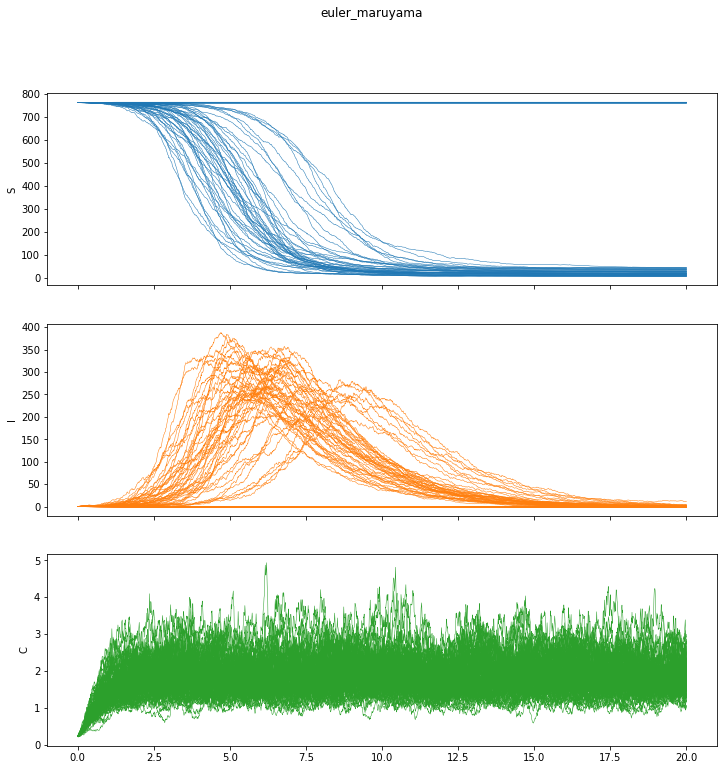

weak_order_2


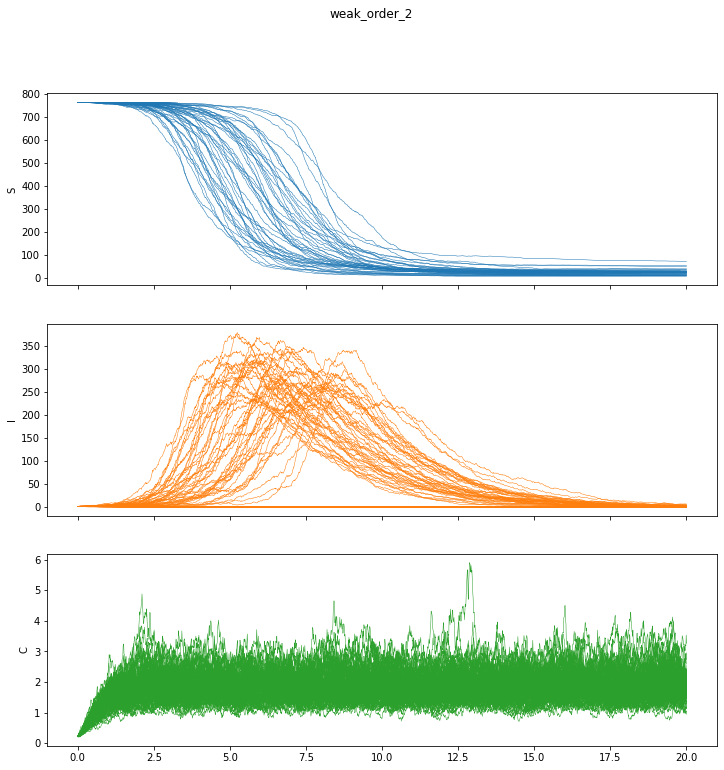

In [4]:
for key, generate_x_seq in generate_x_seq_functions.items():
    print(key)
    dim_n = step_funcs_and_dim_n[key][1]
    n_step = len(t_seq_simulation) - 1
    x_seqs = vmap(generate_x_seq, (None, None, 0, None))(
        x_0_obs, θ_obs, rng_obs.standard_normal((100, n_step, dim_n)), t_seq_simulation)
    fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
    labels = 'SIC'
    for i, ax in enumerate(axes):
        ax.plot(t_seq_simulation, (x_seqs[:, :, i].T), color=f'C{i}', lw=0.5)
        ax.set_ylabel(labels[i])
    fig.suptitle(key)
    display(fig)
    plt.close(fig)

euler_maruyama


Sampling stage: Adaptive warm up [10:26] > Main non-adaptive [11:09]

Chain 1/4: 100%|██████████|1000/1000 [02:27<00:00, 6.77it/s, n_step=895., accept_stat=0.778]

Chain 2/4: 100%|██████████|1000/1000 [02:49<00:00, 5.89it/s, n_step=994., accept_stat=0.930]

Chain 3/4: 100%|██████████|1000/1000 [03:03<00:00, 5.46it/s, n_step=990., accept_stat=0.944]

Chain 4/4: 100%|██████████|1000/1000 [02:48<00:00, 5.92it/s, n_step=997., accept_stat=0.970]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.772,1.464,0.694,5.105,0.727,0.556,4.0,13.0,3.92
β,0.501,0.045,0.420,0.559,0.022,0.017,5.0,18.0,2.45
σ,0.056,0.034,0.013,0.110,0.017,0.013,4.0,19.0,3.53
λ,0.505,0.015,0.478,0.531,0.006,0.004,7.0,43.0,1.56
x_0_2,1.069,0.803,0.342,2.427,0.399,0.306,5.0,12.0,3.10


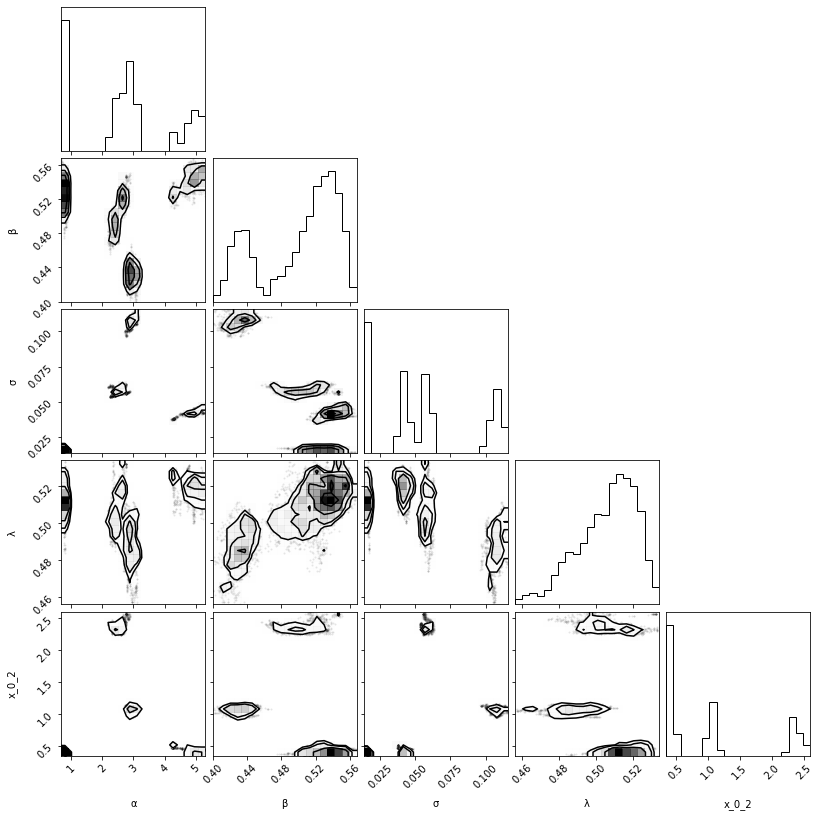

weak_order_2


Sampling stage: Adaptive warm up [14:14] > Main non-adaptive [14:34]

Chain 1/4: 100%|██████████|1000/1000 [03:40<00:00, 4.54it/s, n_step=981., accept_stat=0.916]

Chain 2/4: 100%|██████████|1000/1000 [03:45<00:00, 4.42it/s, n_step=1.00e+03, accept_stat=0.956]

Chain 3/4: 100%|██████████|1000/1000 [03:31<00:00, 4.73it/s, n_step=964., accept_stat=0.911]

Chain 4/4: 100%|██████████|1000/1000 [03:36<00:00, 4.62it/s, n_step=958., accept_stat=0.883]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.312,1.418,0.360,5.013,0.604,0.452,5.0,19.0,2.04
β,0.502,0.085,0.365,0.672,0.038,0.029,6.0,14.0,1.88
σ,0.137,0.113,0.029,0.385,0.046,0.034,6.0,11.0,1.93
λ,0.523,0.025,0.476,0.565,0.011,0.008,6.0,15.0,1.85
x_0_2,1.928,1.582,0.200,5.294,0.711,0.535,5.0,18.0,2.75


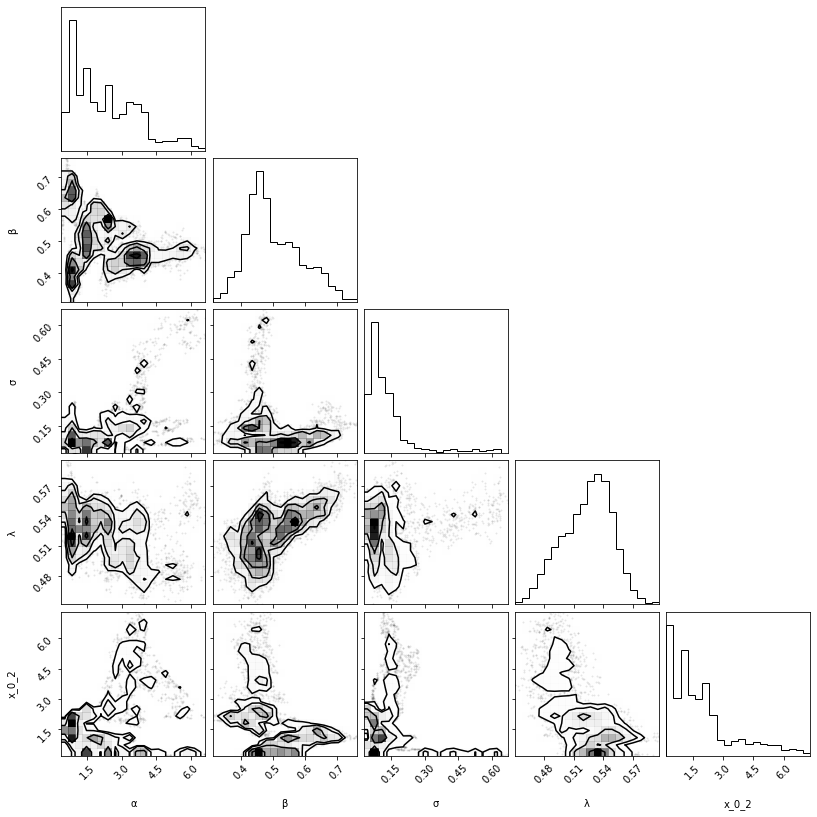

In [4]:
n_chain = 4
n_warm_up_iter = 1000
n_main_iter = 1000
dt_inference = 20 * dt_simulation
t_seq_inference = t_seq_simulation[::int(dt_inference / dt_simulation)]
obs_time_indices = slice(0, None, int(dt_observation / dt_inference))

common_kwargs = {
    "generate_θ": generate_θ,
    "generate_x_0": generate_x_0,
    "obs_func": obs_func,
    "t_seq": t_seq_inference,
    "dim_u": dim_u,
    "dim_v_0": dim_v_0,
    "obs_noise_std": 10.,
    "obs_time_indices": obs_time_indices,
    "y_obs": y_obs
}

for key, generate_x_seq in generate_x_seq_functions.items():
    print(key)
    posterior_density_functions = get_posterior_density_functions(
        generate_x_seq=generate_x_seq, **common_kwargs
    )
    dim_q = (
        common_kwargs["dim_u"] 
        + common_kwargs["dim_v_0"]
        + step_funcs_and_dim_n[key][1] * (len(t_seq_inference) - 1)
    )
    rng = np.random.default_rng(20221114)
    system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
    integrator = mici.integrators.LeapfrogIntegrator(system)
    sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
    adapters = [
        mici.adapters.DualAveragingStepSizeAdapter(0.9),
        #mici.adapters.OnlineVarianceMetricAdapter()
    ]
    init_states = []
    while len(init_states) < n_chain:
        q = rng.standard_normal(dim_q)
        g, v = system._grad_neg_log_dens(q)
        if not (np.any(np.isnan(g)) or np.isnan(v)):
            init_states.append(q)
    #init_states = rng.standard_normal((n_chain, dim_q))
    final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
        n_warm_up_iter=n_warm_up_iter,
        n_main_iter=n_main_iter,
        init_states=init_states,
        monitor_stats=["n_step", "accept_stat"],
        trace_funcs=[trace_func],
        adapters=adapters,
    )
    summary = arviz.summary(traces)
    fig = corner.corner(traces)
    display(summary)
    display(fig)
    plt.close(fig)
